In [1]:
using DataFrames
using Plots
using Pkg
using PyPlot
using Distributions
using Flux
using Flux: @epochs, throttle
using Tracker
using Flux: Data.DataLoader
using DelimitedFiles

┌ Info: CUDAdrv.jl failed to initialize, GPU functionality unavailable (set JULIA_CUDA_SILENT or JULIA_CUDA_VERBOSE to silence or expand this message)
└ @ CUDAdrv /home/michael/.juliapro/JuliaPro_v1.4.1-1/packages/CUDAdrv/b1mvw/src/CUDAdrv.jl:67


# Основные константы
Значение золотого угла

Коэффициенты преломления

Количество точек фронта/поверхности/изображения

Радиус ядра

Максимальное расстояние от оптического элемента до экрана

In [2]:
golden_angle = pi*(3-sqrt(5))
n1=1
n2=1.5
N=64
r=N^(-1/5)
max_L = 1

1

# Функции
## predict_points
Возвращает точки волнового фронта и, одновременно, центры ядерных функций на поверхности

## kernel(x,y)
Функция ядра. В данном скрипте - гауссово ядро. Возвращает значение гауссовой функции в точке (x,y)

## predict_z(N)
Возвращает случайные значения z-коэффициентов, которые участвуют в формировании поверхности - она ими определяется. Значения берутся из нормального распределения с мат.ожиданием=0, дисперсией=1, сами значения берутся из промежутка [-1;0], т.к. сама поверхность выпукла в противоположную сторону от оси

## predict_ff(N)
Возвращает значения самой freeform-поверхности, предсказанные с помощью формулы Надарая-Ватсона по центрам из функции predict_points(N) и с z-коэффициентами из функции predict_z(N)

## refraction(zin)
На вход получает z-коэффициенты из функции predict_z(N). По ним строится аналитическая функция поверхности z(x,y) и производные по направлению. Далее как в вычислениях - нормали, углы, отклонение, орты смещения и конечные точки после преломления - массивы xout, yout, которые и возвращаются

In [3]:
function predict_points(N)
    x = sqrt.(collect(0:N-1))./sqrt(N).*cos.(collect(0:N-1).*golden_angle)
    y = sqrt.(collect(0:N-1))./sqrt(N).*sin.(collect(0:N-1).*golden_angle)
    return hcat(x,y)
end
points = predict_points(N)

function kernel(x,y)
    return exp.(((-(points[:,1].-x).^2).-(points[:,2].-y).^2)./(2*r.^2))
end

function predict_z(N)
    return rand(Truncated(Normal(0, 1), -1, 0), N)
end

function predict_ff(z)
    z_rbf(x,y) = sum(z.*kernel(x,y))/sum(kernel(x,y))
    return z_rbf.(points[:,1],points[:,2])
end

function refraction(zin)
    z(x,y) = sum(zin[1:N].*kernel(x,y))/sum(kernel(x,y))
    dzdx(x,y) = 2.0*sum((points[:,1].-x).*(zin[1:N] - z.(points[:,1], points[:,2])).*kernel(x,y)./(2*r).^2)/sum(kernel(x,y))
    dzdy(x,y) = 2.0*sum((points[:,2].-y).*(zin[1:N] - z.(points[:,1], points[:,2])).*kernel(x,y)./(2*r).^2)/sum(kernel(x,y))
    nx = -dzdx.(points[:,1], points[:,2])
    ny = -dzdy.(points[:,1], points[:,2])
    norm = sqrt.(nx.^2 + ny.^2 + ones(N))
    alpha = acos.(-norm.^(-1))
    beta = asin.(sin.(alpha).*(n1/n2))
    h = abs.(z.(points[:,1], points[:,2]).-zin[N+1]).*tan.(alpha.-beta)
    norms = sqrt.(nx.^2+ny.^2)
    p = -nx./norms
    q = -ny./norms
    xout = points[:,1].+p.*h
    yout = points[:,2].+q.*h
    return vcat(xout,yout)
end

refraction (generic function with 1 method)

# Формирование выборки
## Вход
size - размер выборки (количество пар "поверхность-изображение")

N - количество точек, по которым строится

## Алгоритм
Для каждой пары предсказываются z-коэффициенты (функция predict_z(N)) и расстояние между опт.элементом и экраном (случайное число [0;max_L]), которые помещаются в массив z_ff_L. По этим значениям поверхности и расстояния вычисляется трассировка лучей функцией refraction(z_ff_L), на выходе которой получаем точки изображения.

После чего вся выборка сохраняется в два файла с соответствующими названиями - один содержит поверхности (Y), другой - изображения (X)

In [4]:
function create_sample(size,N)
    print(r)
    print("Create sample with size=",size,", N=",N,"\n")
    X = Array{Float64}(undef, size, 2N)
    Y = Array{Float64}(undef, size, N+1)
    for i in collect(1:size)
        z_ff_L = vcat(predict_z(N),rand(Float64)*max_L)
        X[i,:] = refraction(z_ff_L)
        Y[i,:] = z_ff_L
    end
    print("Write sample in file with size=",size,", N=",N,"\n")
    open(string("X_",N,"_",size,".txt"), "w") do io
        writedlm(io, X)
    end
    open(string("Y_",N,"_",size,".txt"), "w") do io
        writedlm(io, Y)
    end
    return X,Y
end

create_sample (generic function with 1 method)

# Создание выборки
Процесс достаточно затратный по времени, поэтому лишний раз лучше не запускать

In [5]:
#create_sample(10000,N)
#create_sample(100,N)

# Функция потерь
Вычисляется как сумма среднеквадратичной ошибки предсказания изображения (первое слагаемое) и среднеквадратичной ошибки предсказания самой поверхности (второе слагаемое)

In [6]:
function loss(x,y)
    return Flux.mse(x,refraction(model(x)[1:N+1]))+Flux.mse(y,model(x))
end

loss (generic function with 1 method)

# Функция, в которой происходит обучение
## Вход
d - отношение количества нейронов к количеству точек фронта (в дипломе подробнее объясняется с графиками

## Алгоритм
Задается размер обучающей и тестовой выборки и читаются из файлов (для этого они уже должны существовать!). Создается нейросеть (model) и ее параметры (params), оптимизатор (opt). Далее происходит обучение с количеством эпох=1. Возвращается сама модель.

In [10]:
function train_loop(d)
    print("Обучение на ", d*N, " нейронах\n")
    print("Загрузка данных из файла\n")
    train_size = 10000
    X_train, Y_train = readdlm(string("X_",N,"_",train_size,".txt"),Float64),readdlm(string("Y_",N,"_",train_size,".txt"),Float64)
    train_loader = DataLoader(X_train', Y_train', batchsize=10, shuffle=true) 
    test_size = 100
    X_test, Y_test = readdlm(string("X_",N,"_",test_size,".txt"),Float64),readdlm(string("Y_",N,"_",test_size,".txt"),Float64)
    test_loader = DataLoader(X_test', Y_test', batchsize=1, shuffle=true)
    print("Инициализация модели\n")
    global model = nothing
    global params = nothing
    global model = Chain(Dense(2N, Int(d*N)),Dense(Int(d*N), Int(d*N)),Dense(Int(d*N), N+1))
    params = Flux.params(model)
    opt = Flux.ADAM(0.001)
    print("Обучение\n")
    @epochs 1 Flux.train!(loss, params, train_loader, opt, cb = throttle( ()->@show(loss(X_test[1,:],Y_test[1,:])/test_size),10));
    print("DONE\n")
    return model
end

train_loop (generic function with 1 method)

# Обучение
Здесь аргумент функции - соотношение количеств нейронов и точек фронта

При больших размерах выборки и количества точек может считаться долго.

Каждая строка вывода - ошибка на тестовой (независимой рандомной) выборке

In [11]:
model = train_loop(2)

Обучение на 128 нейронахЗагрузка данных из файлаИнициализация моделиОбучение

┌ Info: Epoch 1
└ @ Main /home/michael/.juliapro/JuliaPro_v1.4.1-1/packages/Flux/NpkMm/src/optimise/train.jl:119


loss(X_test[1, :], Y_test[1, :]) / test_size = 0.003451298312518172
loss(X_test[1, :], Y_test[1, :]) / test_size = 0.000987415475904952
loss(X_test[1, :], Y_test[1, :]) / test_size = 0.001002956375521258
loss(X_test[1, :], Y_test[1, :]) / test_size = 0.0007811622449791223
loss(X_test[1, :], Y_test[1, :]) / test_size = 0.0009012128871504762
loss(X_test[1, :], Y_test[1, :]) / test_size = 0.0007716146184209069
loss(X_test[1, :], Y_test[1, :]) / test_size = 0.0009401296551993867
loss(X_test[1, :], Y_test[1, :]) / test_size = 0.0007895604830612228
loss(X_test[1, :], Y_test[1, :]) / test_size = 0.000818170703543765
loss(X_test[1, :], Y_test[1, :]) / test_size = 0.0008634269709269048
loss(X_test[1, :], Y_test[1, :]) / test_size = 0.0007574063307444894
loss(X_test[1, :], Y_test[1, :]) / test_size = 0.0008343592841783946
loss(X_test[1, :], Y_test[1, :]) / test_size = 0.0007876593642344745
loss(X_test[1, :], Y_test[1, :]) / test_size = 0.0008878019468899436
loss(X_test[1, :], Y_test[1, :]) / tes

Chain(Dense(128, 128), Dense(128, 128), Dense(128, 65))

# Проверка работоспособности модели. Рандом
## Разброс точек - точки фронта (синие), исходное изображение (красные), предсказанное изображение (зеленые)

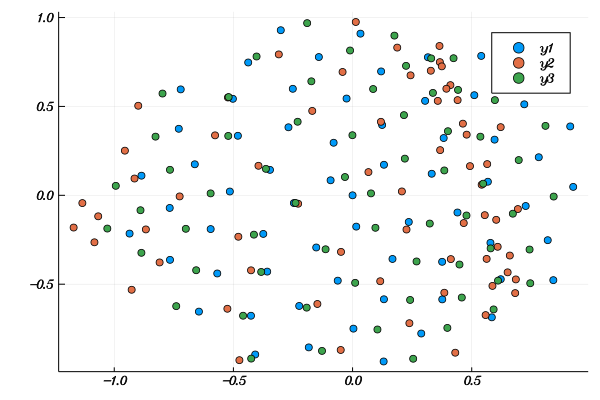

In [13]:
z_ff_L = vcat(predict_z(N),rand(Float64)*5)
image = refraction(z_ff_L)
z_ff_L_pred = model(image)
image_pred = refraction(z_ff_L_pred)
#print("Ошибка на изображении ",Flux.mse(image, image_pred), "\n")
#print("Ошибка на изображении ",Flux.mse(z_ff_L, z_ff_L_pred), "\n")
#print(image)
Plots.plot()
Plots.plot!(points[:,1],points[:,2], st=:scatter)
Plots.plot!(image[1:N],image[N+1:2N], st=:scatter)
Plots.plot!(image_pred[1:N],image_pred[N+1:2N], st=:scatter)#,xlim=(-1,1),ylim=(-1,1))

# Проверка работоспособности на заданной поверхности

Для этого в z_ff нужно поместить формулу поверхности (или функцию, которая ее вычисляет). Здесь приведена функция сферы. Важно, чтобы поверхность была повернута в отрицательную сторону оси z, ее значения были <1 и она была относительно гладкая (без очень высоких градиентов) - это текущие ограничения модели.

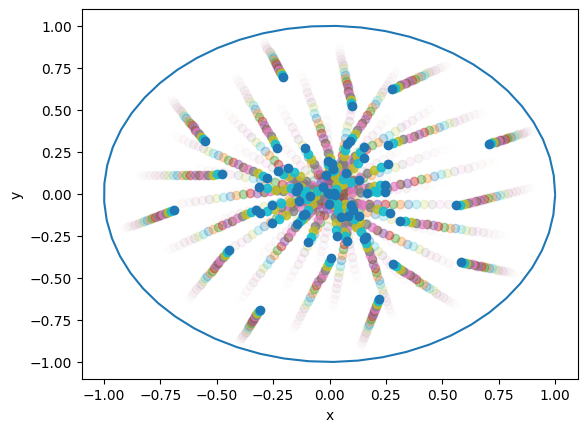

128-element Array{Float64,1}:
  0.0017433730439148204
 -0.08355195069537552
  0.017280135161118426
  0.12090249695240916
 -0.227523953978658
  0.2181498966978344
 -0.07370786365165309
 -0.13884563210779557
  0.30653492488599915
 -0.32720721127260977
  0.1592438463785159
  0.1153866382991274
 -0.3542351952696954
  ⋮
 -0.6757353596941736
  0.9076050722119716
 -0.6474988917620116
  0.04070300752752054
  0.5946532417294278
 -0.9218704576755536
  0.7952397496858628
 -0.21378150375761926
 -0.4829618755397506
  0.9300283599580697
 -0.8910753975152036
  0.3958729132910076

In [14]:
z_ff = -sqrt.(ones(N).-(points[:,1].^2).-(points[:,2].^2)).*0.5
plt = PyPlot.plot()
xlim=(-1,1)
im = []
push!(plt, PyPlot.plot(cos.(collect(0:0.11:2pi)), sin.(collect(0:0.11:2pi))))
xlabel("x")
ylabel("y")
for L in collect(0:0.5:10)
    im = refraction(vcat(z_ff,L))
    push!(plt,PyPlot.scatter(im[1:N], im[N+1:2N], alpha=(L/10)^2))
#    Plots.savefig(string("dispersion",L,".png"))
end
PyPlot.savefig("spher_dispersion.png")
z_ff_L = vcat(z_ff,1)
image = refraction(z_ff_L)
z_ff_L_pred = model(image)
image_pred = refraction(z_ff_L_pred)

# Графики (для заданной поверхности)

Создание разного рода графиков
1. Поверхности
2. Предсказанной поверхности
3. Тепловой карты ошибки предсказания поверхности
4. Гистограмма ошибки изображения
5. Точки изображения и поверхности на одной картинке для сравнения

In [15]:
Plots.plot(collect(-1:0.01:1), collect(-1:0.01:1), (x,y) -> x^2+y^2 <= 1 ? -sum(z_ff_L[1:N].*kernel(x,y))/sum(kernel(x,y)) : 0.31, zlim=(0.3,0.6), st=:surface, xlabel="x", ylabel="y", zlabel="z")
#Plots.plot(points[:,1], points[:,2], z_ff_L[1:N], st=:surface)
Plots.savefig("spher_surface.png")

In [16]:
Plots.plot(collect(-1:0.01:1), collect(-1:0.01:1), (x,y) -> x^2+y^2 <= 1 ? -sum(z_ff_L_pred[1:N].*kernel(x,y))/sum(kernel(x,y)) : 0.41, zlim=(0.4,0.65), st=:surface, xlabel="x", ylabel="y", zlabel="z")
#Plots.plot(points[:,1], points[:,2], z_ff_L_pred[1:N], st=:surface)
Plots.savefig("spher_surface_pred.png")

In [17]:
Plots.plot()
Plots.plot!(collect(-1:0.01:1), collect(-1:0.01:1), (x,y) -> (sum(z_ff_L_pred[1:N].*kernel(x,y))/sum(kernel(x,y))-sum(z_ff_L[1:N].*kernel(x,y))/sum(kernel(x,y)))^2, st=:heatmap, xlabel="x", ylabel="y")
Plots.savefig("spher_heatmap.png")

In [18]:
Plots.histogram((image.-image_pred).^2, xlabel="error", ylabel="count")
Plots.savefig("spher_histogram.png")

In [19]:
Plots.plot(image[1:N],image[N+1:2N], st=:scatter, xlabel="x", ylabel="y")
Plots.plot!(image_pred[1:N],image_pred[N+1:2N], st=:scatter)
Plots.savefig("spher_points.png")

# Графики для произвольной поверхности

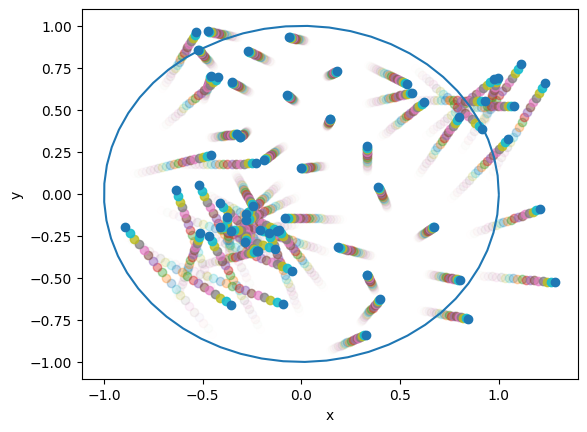

128-element Array{Float64,1}:
 -0.017845809026540527
 -0.10699853492047928
 -0.005597541733979937
  0.12247242165932344
 -0.25237839981904475
  0.21832903411481713
 -0.09292467220854525
 -0.1672371798981205
  0.3338726965137172
 -0.3461508777958749
  0.14642858406158793
  0.1215718607625026
 -0.3695820623955494
  ⋮
 -0.6911426050868
  0.9197131935029842
 -0.6284042530637661
  0.09174280982590996
  0.6248569696022855
 -0.9171902776143089
  0.7775575721441245
 -0.24480410734389452
 -0.4835870317223138
  0.9321110644992499
 -0.8560175668368277
  0.4143903017164417

In [20]:
N=64
z_ff = predict_z(N)
plt = PyPlot.plot()
xlim=(-1,1)
im = []
push!(plt, PyPlot.plot(cos.(collect(0:0.11:2pi)), sin.(collect(0:0.11:2pi))))
xlabel("x")
ylabel("y")
for L in collect(0:0.5:10)
    im = refraction(vcat(z_ff,L))
    push!(plt,PyPlot.scatter(im[1:N], im[N+1:2N], alpha=(L/10)^2))
#    Plots.savefig(string("dispersion",L,".png"))
end
PyPlot.savefig("dispersion.png")
z_ff_L = vcat(z_ff,1)
image = refraction(z_ff_L)
z_ff_L_pred = model(image)
image_pred = refraction(z_ff_L_pred)

In [21]:
Plots.plot(collect(-1:0.01:1), collect(-1:0.01:1), (x,y) -> -sum(z_ff_L[1:N].*kernel(x,y))/sum(kernel(x,y)), zlim=(0.3,0.8), st=:surface, xlabel="x", ylabel="y", zlabel="z")
#Plots.plot(points[:,1], points[:,2], z_ff_L[1:N], st=:surface)
Plots.savefig("surface.png")

In [22]:
Plots.plot(collect(-1:0.01:1), collect(-1:0.01:1), (x,y) -> -sum(z_ff_L_pred[1:N].*kernel(x,y))/sum(kernel(x,y)), zlim=(0.3,0.8), st=:surface, xlabel="x", ylabel="y", zlabel="z")
#Plots.plot(points[:,1], points[:,2], z_ff_L_pred[1:N], st=:surface)
Plots.savefig("surface_pred.png")

In [23]:
Plots.plot()
Plots.plot!(collect(-1:0.01:1), collect(-1:0.01:1), (x,y) -> (sum(z_ff_L_pred[1:N].*kernel(x,y))/sum(kernel(x,y))-sum(z_ff_L[1:N].*kernel(x,y))/sum(kernel(x,y)))^2, st=:heatmap, xlabel="x", ylabel="y")
Plots.savefig("heatmap.png")

In [24]:
Plots.histogram((image.-image_pred).^2, xlabel="error", ylabel="count")
Plots.savefig("histogram.png")

In [25]:
Plots.plot(image[1:N],image[N+1:2N], st=:scatter, xlabel="x", ylabel="y")
Plots.plot!(image_pred[1:N],image_pred[N+1:2N], st=:scatter)
Plots.savefig("points.png")